### 데이터 살펴보기

메서드 불러오기

In [1]:
# 기본 패키지
import pandas as pd
import numpy as np

# 시각화 패키지
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='NanumBarunGothic') 
plt.style.use(['ggplot'])

# 변수 생성 패키지
import datetime

# 모든 열 출력
pd.set_option('display.max_columns', None)

# 한글 시각화시 필요 모듈
import platform # 사용자 운영체제 확인
platform.system()
## 운영체제별 한글 폰트 설정
if platform.system() == 'Darwin': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')

plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정
## 글씨 선명하게 출력하는 설정
%config InlineBackend.figure_format = 'retina'


# 경고 메시지 무시
import warnings
warnings.filterwarnings(action='ignore') 


# 버전 확인
print('Pandas : %s'%(pd.__version__))
print('seaborn : %s'%(sns.__version__))
print('matplotlib : %s'%(matplotlib.__version__))
!python --version

Pandas : 1.4.3
seaborn : 0.11.2
matplotlib : 3.5.1
Python 3.8.8


In [2]:
# 데이터 불러오기
user = pd.read_csv('../data/user_spec.csv')
loan = pd.read_csv('../data/loan_result.csv')
# log = pd.read_csv('../data/log_data.csv')

### 1. 유저 스펙 테이블

- na값에 대한 확인

In [3]:
user.isna().sum()

application_id                               0
user_id                                      0
birth_year                               12961
gender                                   12961
insert_time                                  0
credit_score                            105115
yearly_income                               90
income_type                                 85
company_enter_month                     171760
employment_type                             85
houseown_type                               85
desired_amount                              85
purpose                                     85
personal_rehabilitation_yn              587461
personal_rehabilitation_complete_yn    1203354
existing_loan_cnt                       198556
existing_loan_amt                       313774
dtype: int64

    - birth_year와 gender 결측값 채워줌

In [4]:
###### birth_year #####
birth_year_mean = user['birth_year'].mean()
user['birth_year'] = user['birth_year'].fillna('없음')

# 전처리할 데이터 재생성
bir = user.groupby('user_id')['birth_year'].apply(set).reset_index()
bir['len'] = bir['birth_year'].apply(lambda x:len(x))

# 0을 지워주는 함수 생성
def remove0(x):
    if len(x) == 2: 
        x_ = x.remove('없음')
        return x_
    else: return x

# 적용
bir['birth_year'].apply(remove0)
bir['year'] = bir['birth_year'].apply(lambda x:list(x)[0])

# 없음을 평균으로 채워줌
bir['year'] = bir['year'].apply(lambda x:birth_year_mean if x == '없음' else x)

In [5]:
# 딕셔너리로 변환하여 저장
birth_year = {x:y for x,y in zip(bir['user_id'], bir['year'])}

# 적용하여 변환
user['birth_year'] = user['user_id'].apply(lambda x:birth_year[x])

In [6]:
###### gender #####
user['gender'] = user['gender'].fillna('없음')

# 전처리할 데이터 재생성
g = user.groupby('user_id')['gender'].apply(set).reset_index()
g['len'] = g['gender'].apply(lambda x:len(x))

# 0을 지워주는 함수 생성
def remove2(x):
    if len(x) == 2: 
        x_ = x.remove('없음')
        return x_
    else: return x

# 적용
g['gender'].apply(remove2)
g['g'] = g['gender'].apply(lambda x:list(x)[0])
g['g'] = g['g'].apply(lambda x:1 if x == '없음' else x)

# 딕셔너리로 변환하여 저장
gender = {x:y for x,y in zip(g['user_id'], g['g'])}

# 적용하여 변환
user['gender'] = user['user_id'].apply(lambda x:gender[x])

    - personal_rehabilitation_complete_yn
        -> 문의 필요

In [7]:
# na값을 확인 하였을 때, personal_rehabilitation_complete_yn의 값이 높은데, 이는 개인 회생자가 아닌 사람도 포함 돼있기 때문으로 보임
## na중 personal_rehabilitation_yn의 값이 0인 값은 개인회생자 아님 등으로 채워야할 듯함
user[user['personal_rehabilitation_complete_yn'].isna()]['personal_rehabilitation_yn'].unique()

array([ 0., nan])

In [8]:
user.query('personal_rehabilitation_yn == 0')['personal_rehabilitation_complete_yn'].value_counts()

0.0    178149
1.0         4
Name: personal_rehabilitation_complete_yn, dtype: int64

In [9]:
user.query('personal_rehabilitation_yn == 1')['personal_rehabilitation_complete_yn'].value_counts()

0.0    11361
1.0     1348
Name: personal_rehabilitation_complete_yn, dtype: int64

분포를 확인해보았을 때, personal_rehabilitation_complete_yn에 기록이 있으면 personal_rehabilitation_yn가 1인 것으로 생각하여 채워야될듯함

In [10]:
# 기록이 있으면 개인회생자, 없으면 아닌 사람으로 기록
user['personal_rehabilitation_yn'] = user['personal_rehabilitation_complete_yn'].apply(lambda x:1 if x in [0,1] else 0)
# 나머지 기록이 na인 값은 전부 개인회생자가 아닌 것으로 확인함 -> 2( 개인회생자아님 )로 채워줌
user['personal_rehabilitation_complete_yn'] = user['personal_rehabilitation_complete_yn'].fillna(2)

    - company_enter_month

In [11]:
# company_enter_month에 대한 na값은 입사 년월을 입력하지 못하는 사람들이 대부분임
## 입사년월이 없는 사람 (ex)개인 사업, 소득이 회사가 아닌 경우 등 )
## 다른 옵션으로 채워야할듯함
user[user['company_enter_month'].isna()]['income_type'].value_counts()

OTHERINCOME        171665
EARNEDINCOME            7
PRIVATEBUSINESS         3
Name: income_type, dtype: int64

In [12]:
# 나중에 채워줄 값을 저장
company_enter_mean = user['company_enter_month'].mean()
# OTHERINCOME을 제외하면 na값이 적기 때문에 입사년도 없음으로 채워줌
user['company_enter_month'] = user['company_enter_month'].fillna('입사년도 없음')

    - credit_score

In [13]:
# 68018명의 사람들의 신용정보 확인 불가능
user[['user_id', 'credit_score']].drop_duplicates(subset='user_id').isna().sum()

user_id             0
credit_score    68018
dtype: int64

In [14]:
# 신용 점수가 있는 고객들은 해당 고객이 가진 신용 점수의 평균으로 채워줌
user['credit_score'] = user['credit_score'].fillna(user.groupby('user_id')['credit_score'].transform('mean'))

In [15]:
# 채운 후에도 na값인 경우는 신용 점수를 확인한 적이 한번도 없는 고객임
user[user['credit_score'].isna()].groupby('user_id')['credit_score'].count().unique()

array([0], dtype=int64)

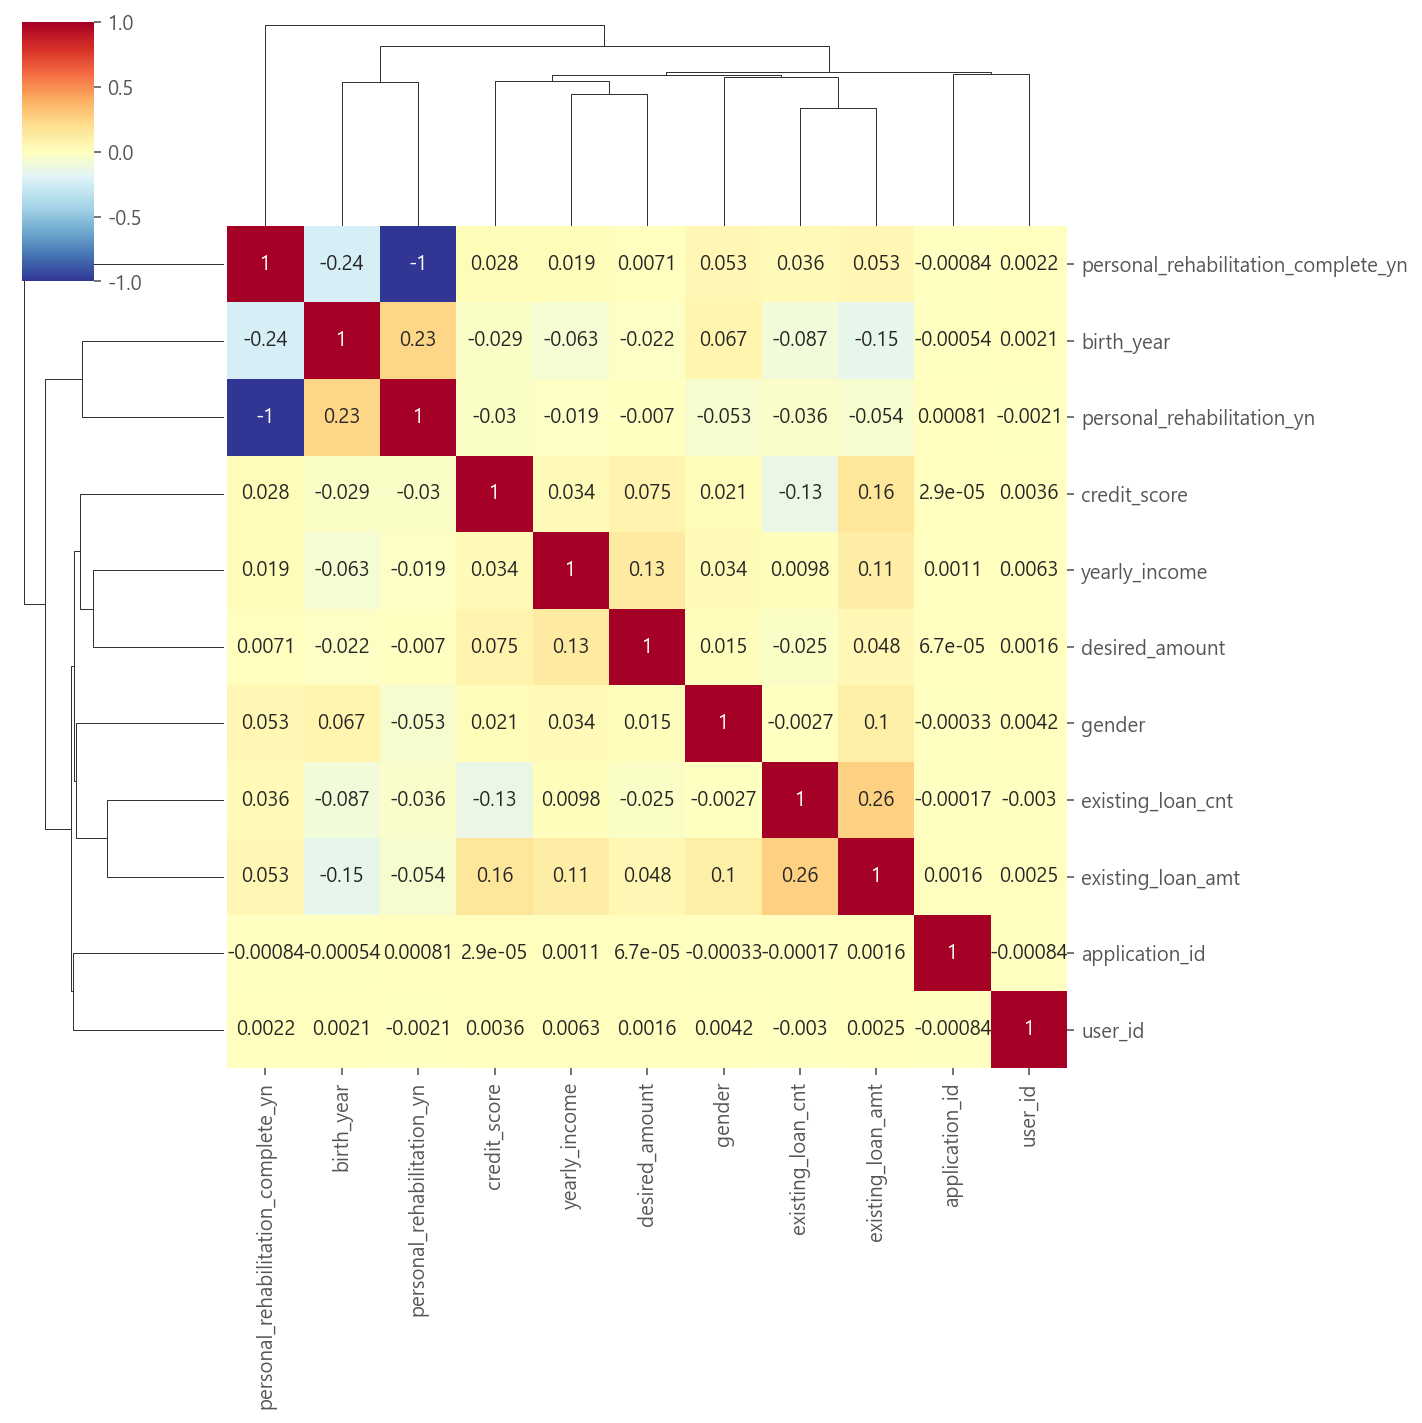

In [16]:
# 컬럼들과 credit score간의 상관관계를 시각화해 보았으나 의미 X 그냥 평균으로 채움

sns.clustermap(user.corr(), 
               annot = True,      # 실제 값 화면에 나타내기
               cmap = 'RdYlBu_r',  # Red, Yellow, Blue 색상으로 표시
               vmin = -1, vmax = 1, #컬러차트 -1 ~ 1 범위로 표시
              )

In [17]:
# 평균으로 채워줌
user['credit_score'] = user['credit_score'].fillna(user['credit_score'].mean())

    - existing_loan_cnt

In [18]:
# existing_loan_cnt의 값이 0인 행이 없는 것으로 보아 na인 경우는 기대출수가 0이지 않을까 하는 추축
user[user['existing_loan_cnt'] == 0]

,application_id,user_id,birth_year,gender,insert_time,credit_score,yearly_income,income_type,company_enter_month,employment_type,houseown_type,desired_amount,purpose,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt


In [19]:
# existing_loan_cnt가 na인 값의 amt는 모두 na인 모습을 보임
user[user['existing_loan_cnt'].isna()][['existing_loan_cnt','existing_loan_amt']].isna().sum()

existing_loan_cnt    198556
existing_loan_amt    198556
dtype: int64

In [20]:
# existing_loan_cnt와 existing_loan_amt의 수가 na인 값은 0으로 채워줌
user['existing_loan_cnt'] = user['existing_loan_cnt'].fillna(0)
user['existing_loan_amt'] = user['existing_loan_amt'].fillna(0)

    - yearly_income, income_type

In [21]:
# 연소득이 na인 값의 소득 경로를 확인해 본 결과 na인 값이 85개, 다른 수익 4, 프리랜서가 1인 모습을 보임
## -> 즉, na인 것은 연소득이 없다는 뜻임
user[user['yearly_income'].isna()]['income_type'].value_counts()

OTHERINCOME    4
FREELANCER     1
Name: income_type, dtype: int64

In [22]:
# 0으로 채워줌
user['yearly_income'] = user['yearly_income'].fillna(0)
user['income_type'] = user['income_type'].fillna('직장없음')

    - employment_type

In [23]:
# employment_type의 경우 company_enter_month의 값이 입사년도없음임
user[user['employment_type'].isna()]['company_enter_month'].unique()

array(['입사년도 없음'], dtype=object)

In [24]:
# 입사년도가 없다는 것은 기타이기 때문에 기타로 채워줌
user['employment_type'] = user['employment_type'].fillna('기타')

    - houseown_type

In [25]:
# houseown_type이 na인 값은 그냥 귀찮아서 안찍은듯함
user['houseown_type'].unique()

array(['자가', '기타가족소유', '전월세', '배우자', nan], dtype=object)

In [26]:
## -> 정보없음으로 채워줌
user['houseown_type'] = user['houseown_type'].fillna('정보없음')

    - desired_amount

In [27]:
# 이 경우도 선택을 그냥 하지 않은 경우이기 때문에 최빈값으로 채워줌
## 단순한 궁금증으로 인하여 선택을 한 경우라고 판단 -> 가장 많이 원하는 금액으로 채움
user['desired_amount'] = user['desired_amount'].fillna(user['desired_amount'].mode()[0])

    - purpose

In [28]:
# 목적 또한 위와 같음
## 최빈값으로 채움
user['purpose'] = user['purpose'].fillna(user['purpose'].mode()[0])

In [29]:
user.isna().sum()

application_id                         0
user_id                                0
birth_year                             0
gender                                 0
insert_time                            0
credit_score                           0
yearly_income                          0
income_type                            0
company_enter_month                    0
employment_type                        0
houseown_type                          0
desired_amount                         0
purpose                                0
personal_rehabilitation_yn             0
personal_rehabilitation_complete_yn    0
existing_loan_cnt                      0
existing_loan_amt                      0
dtype: int64

### 2. 대출 상품 결과 테이블

- 중복값을 갖는 행 처리

In [30]:
# 데이터가 중복인 경우가 25개 존재하여 삭제해줌
len(loan[loan.duplicated()])

26

In [31]:
# 중복 제거하여 데이터 선언
loan = loan.drop_duplicates()

- 결측값 처리

In [32]:
loan.isna().sum()

application_id                 0
loanapply_insert_time          0
bank_id                        0
product_id                     0
loan_limit                  7495
loan_rate                   7495
is_applied               3257223
dtype: int64

In [33]:
# loan_limit과 loan_rate는 동일한 행에서 na값을 가짐을 확인
loan[loan['loan_limit'].isna()]['loan_rate'].unique()

array([nan])

In [34]:
# 타겟값에 대한 확인을 위해 월별로 확인
loan['month'] = loan['loanapply_insert_time'].apply(lambda x:int(x[5:7]))

# train data의 경우 loan_limit과 loan_rate가 na인 경우 타겟값이 모두 1임을 알 수 있음
loan[(loan['loan_limit'].isna()) & (loan['month'] != 6)]['is_applied'].value_counts()

1.0    5738
Name: is_applied, dtype: int64

In [35]:
# 전체 타겟값 대비 1% 정도가 위와 같은 모습을 보임
## -> 비슷한 형태를 띄는 행으로 결측값 대체
loan['is_applied'].value_counts()

0.0    9709673
1.0     560441
Name: is_applied, dtype: int64

    - loan_rate

In [36]:
# 일부 행만 null인 경우 결측치를 product별 평균
product_list = loan[loan['loan_limit'].isna()]['product_id'].unique()

for i in product_list:
    len_rate = loan[loan['product_id'] == i]['loan_rate'].unique()
    
    if len(len_rate) > 1:
        loan.loc[(loan['product_id'] == i) & (loan['loan_rate'].isna()), 'loan_rate'] = round(np.nanmean(len_rate), 1)

        
# 모두 null인 경우 결측치를 application별 평균
loan['loan_rate'] = loan['loan_rate'].fillna(loan.groupby('application_id')['loan_rate'].transform('mean'))

# application이 하나인 데이터 최빈값 대체
loan['loan_rate'] = loan['loan_rate'].fillna(loan['loan_rate'].mode()[0])

    - loan_limit

In [37]:
# loan_limit 결측치를 application별로 평균
loan['loan_limit'] = loan['loan_limit'].fillna(loan.groupby('application_id')['loan_limit'].transform('mean'))

# application이 하나인 결측치 최빈값으로
loan['loan_limit'] = loan['loan_limit'].fillna(loan['loan_limit'].mode()[0])

## 변수 생성

- user

입사년도 년,월,일 -> 일 제거

In [38]:
user['company_enter_month'] = user['company_enter_month'].apply(lambda x : x if x == "입사년도 없음" else str(x)[:6])

In [39]:
### 대출 이력 ###
# 대출 이력이 있는 고객은1 없는 고객은 0으로 채워줌
true_list = loan[loan['is_applied'] == 1]['application_id'].unique()
user['loan_history'] = user['application_id'].apply(lambda x:1 if x in true_list else 0)

In [40]:
### insert time 날짜 변경 ### 
# insert time : 한도조회 당시 시간
user['insert_time'] = pd.to_datetime(user['insert_time'])

In [41]:
### 나이 ###
# 현시점의 나이를 계산해서 변수로 생성
user['age'] = user['birth_year'].apply(lambda x:2022 - x if x!= '없음' else x)

In [42]:
### 연령대 ###
user['age_group'] = user['age'].apply(lambda x:f'{str(x)[0]}0대' if x != '없음' else x)

In [43]:
### 신용등급 ###
# finda 신용등급은 코리아크레딧뷰로(KCB)사용
def credit_rating(x):
    if x >= 942:return 1
    elif x >= 891:return 2
    elif x >= 832:return 3
    elif x >= 768:return 4
    elif x >= 698:return 5
    elif x >= 630:return 6
    elif x >= 530:return 7
    elif x >= 454:return 8
    elif x >= 335:return 9
    else:return 10
    
user['credit_rating'] = user['credit_score'].apply(credit_rating)

In [44]:
### 소득등급 ###
# 상세 소득수준(ex.연령대별 평균과 비교) or 세분화된 소득분위(ex.10등급으로 세분, 장학재단에서 사용하는 소득분위) 추가
percent = user['yearly_income'].describe()

def income_rating(x):
    if x < percent[4]:return 4
    elif x < percent[5]:return 3
    elif x < percent[6]:return 2
    else:return 1

user['income_rating'] = user['yearly_income'].apply(income_rating)

In [45]:
### 근속년수 ###
user['service_year'] = user['company_enter_month'].apply(lambda x:2022- int(str(x)[:4]) + 1 if x != '입사년도 없음' else 0)

In [46]:
### 기대출 평균 금액 ###
user['avg_existing_loan_amt'] = user['existing_loan_amt'] / user['existing_loan_cnt']
user['avg_existing_loan_amt'] = user['avg_existing_loan_amt'].fillna(user['avg_existing_loan_amt'].mean())

In [47]:
### 대출 조회 건수 ###
count = user.groupby('user_id')['application_id'].count()
user['application_count'] = user['user_id'].apply(lambda x : count[x])

In [48]:
### 신용평가 시간 ###
def insert_classification(x):
    if 2 <= x <= 5:return "새벽"
    elif x <= 9:return "아침"
    elif x <= 13:return "점심"
    elif x <= 18:return "낮"
    elif x <= 22:return "저녁"
    else:return "밤"

user['insert_classification'] = user['insert_time'].dt.hour.apply(insert_classification)

In [49]:
### income_type 별 소득 수준 ###
income_type = user.groupby('income_type')['yearly_income'].agg('median')

user['income_income_level'] = user.apply(lambda x: "직장없음" if x['income_type'] == "직장없음" else 
                                         ("평균 미만" if x['yearly_income'] < income_type[x['income_type']] else "평균 이상"), axis = 1)

In [50]:
### 연소득 대비 대출 희망금액 비율 ###
user['income_desired_ratio'] = user['desired_amount'] / (user['yearly_income']+0.01)

In [51]:
### 연소득 대비 기대출 금액 비율 ###
user['income_existing_ratio'] = user['existing_loan_amt'] / (user['yearly_income']+0.01)

In [52]:
### 이직 횟수 ###
change = user.groupby('user_id')['company_enter_month'].nunique()

user['turnover_count'] = user['user_id'].apply(lambda x : change[x])

In [53]:
### 최고희망금액 - 최저희망금액 ###
desired_change = user.groupby('user_id')['desired_amount'].apply(lambda x : x.max()-x.min())

user['desired_change'] = user['user_id'].apply(lambda x : desired_change[x])

In [54]:
# 본인과 근로 형태가 같은 사람들의 중위소득 금액 대비 본인 소득 비율
income_ratio = user.groupby('income_type')['yearly_income'].agg('median')

def income_rt(x):
    if x['income_type'] =="EARNEDINCOME":
        return x['yearly_income']/income_ratio[0] * 100
    elif x['income_type'] =="EARNEDINCOME2":
        return x['yearly_income']/income_ratio[1] * 100
    elif x['income_type'] =="FREELANCER":
        return x['yearly_income']/income_ratio[2] * 100
    elif x['income_type'] =="OTHERINCOME":
        return x['yearly_income']/income_ratio[3] * 100
    elif x['income_type'] =="PRACTITIONER":
        return x['yearly_income']/income_ratio[4] * 100
    elif x['income_type'] =="PRIVATEBUSINESS":
        return x['yearly_income']/income_ratio[5] * 100
    
user['income_ratio'] = user.apply(lambda x: income_rt(x), axis=1)

    - DNN에 넣기 위해 값 처리

In [55]:
# company_enter_month의 입사년도 없음을 평균 값으로 처리
user['company_enter_month'] = user['company_enter_month'].apply(lambda x:company_enter_mean if x == '입사년도 없음' else x).astype(int)

- loan

In [56]:
### loanapply_insert_time 날짜 변경 ###
loan['loanapply_insert_time'] = pd.to_datetime(loan['loanapply_insert_time'])

In [57]:
# 승인 한도 수준
limit_mean = loan['loan_limit'].mean()

loan['loan_limit_level'] = loan['loan_limit'].apply(lambda x: "평균 미만" if x < 
                                      limit_mean else "평균 이상")

In [58]:
# 승인 금리 수준
rate_mean = loan['loan_rate'].mean()

loan['loan_rate_level'] = loan['loan_rate'].apply(lambda x: "평균 미만" if x < 
                                      rate_mean else "평균 이상")

In [59]:
# 추천 은행별 평균 승인 한도
bank_limit = loan.groupby("bank_id")['loan_limit'].agg("mean")

loan['bank_limit_avg'] = loan['bank_id'].apply(lambda x : bank_limit[x])

In [60]:
# 은행별 평균 승인 금리
bank_rate = loan.groupby("bank_id")['loan_rate'].agg("mean")

loan['bank_rate_avg'] = loan['bank_id'].apply(lambda x : bank_rate[x])

## 데이터 병합 및 저장

In [61]:
# 데이터 병합
data = pd.merge(loan, user, on = "application_id").reset_index(drop = True)
# 예측을 위한 pk는 인덱스이기 때문에 불러올때 인덱스를 컬럼으로 가져옴
data = data.reset_index()

In [62]:
# 사용자별 추천 은행 갯수
n_bank = data.groupby('user_id')['bank_id'].nunique()
data['n_bank'] = data['user_id'].apply(lambda x: n_bank[x])

In [63]:
# 사용자별 추천 상품 갯수
n_product = data.groupby('user_id')['product_id'].nunique()
data['n_product'] = data['user_id'].apply(lambda x: n_product[x])

In [64]:
# 사용자별 은행당 평균 상품 추천수
data['bank_product_ratio'] = data['n_product'] / data['n_bank']

In [65]:
#### loan_coefficient 변수 생성 ####
# 신청한 대출을 예측할 수 있는 지수를 계산하여 변수로 생성
## -> 희망 금액과 승인 금액이 비슷할수록 값은 1에 가깝게 작게 나타나고 , 승인 금리가 적을 수록 1에 가까움
## -> 즉, 직관적으로 사용자가 원하는 상황과 비슷할 경우 값은 1과 가깝게, 사용자가 원하지 않는 상품일 경우 큰 값을 가짐
def loan_coefficient(loan_limit, loan_rate, desired_amount):
    if loan_limit < desired_amount:
        return (desired_amount-loan_limit)*loan_rate
    elif loan_limit > desired_amount:
        return (loan_limit-desired_amount)*loan_rate
    else: return loan_rate

# 적용해줌
data['loan_coefficient'] = data.apply(lambda x:loan_coefficient(x['loan_limit'], x['loan_rate'], x['desired_amount']), axis=1)

In [66]:
# 해당 은행을 추천받은 사용자의 평균 신용 등급을 구해줌
user_credit = data.groupby('bank_id')['credit_score'].agg("mean")

data['bank_user_credit'] = data['bank_id'].apply(lambda x: user_credit[x])

In [67]:
# datetime 인코딩 문제로 object로 변경
data['loanapply_insert_time'] = data['loanapply_insert_time'].astype(str)
data['insert_time'] = data['insert_time'].astype(str)

- 데이터 저장

In [68]:
# 데이터 저장
data.to_csv('../data/make_feature.csv', index = False)

## END